In [2]:
import pygraphviz as pgv
from IPython.display import SVG
from neo4j import GraphDatabase
import networkx as nx
import enum
from tqdm.notebook import tqdm

In [3]:
valid_smoothing_types = ["none","avg_dist","graph_dist","power_dist","rng","spring","triangle"]
#class ValidSmoothing(enum.StrEnum):
#    none = auto()
    
def drawSVGsfdp(G : pgv.AGraph, renderToNotebook : bool=True, repulsiveforce : float=1.0, K :float=0.3, smoothing_type : str="none", svg_fname : str='/home/ubuntu/PROJECTS/BIG_ROBOKOP_MAP/graph.svg'):
    if(smoothing_type not in valid_smoothing_types):raise ValueError
    G.layout(prog="sfdp", args=f"-Glevels=4 -Goverlap=scale -Grepulsiveforce={repulsiveforce} -GK={K} -Gsmoothing={smoothing_type}")
    G.draw(svg_fname)
    if(renderToNotebook): return SVG(svg_fname)

def drawSVGneato(G : pgv.AGraph, renderToNotebook : bool=True, svg_fname : str='/home/ubuntu/PROJECTS/BIG_ROBOKOP_MAP/graph.svg'):
    G.layout(prog="neato", args=f"")
    G.draw(svg_fname)
    if(renderToNotebook): return SVG(svg_fname)

def drawSVGdot(G : pgv.AGraph, renderToNotebook : bool=True, svg_fname : str='/home/ubuntu/PROJECTS/BIG_ROBOKOP_MAP/graph.svg'):
    G.layout(prog="dot", args=f"")
    G.draw(svg_fname)
    if(renderToNotebook): return SVG(svg_fname)

def drawSVGtwopi(G : pgv.AGraph, renderToNotebook : bool=True, root : str="N/A", svg_fname : str='/home/ubuntu/PROJECTS/BIG_ROBOKOP_MAP/graph.svg'):
    G.layout(prog="twopi", args=f"-Groot={root}")
    G.draw(svg_fname)
    if(renderToNotebook): return SVG(svg_fname)

In [4]:


driver = GraphDatabase.driver('bolt://robokopkg.renci.org:7687', auth=("", ""))

query = """
MATCH (d:`biolink:DiseaseOrPhenotypicFeature`)-[r1]-(g:`biolink:Gene`)-[r2]-(c:`biolink:ChemicalEntity`) WHERE toLower(d.name) CONTAINS "castleman disease" AND EXISTS(c.smiles) RETURN * LIMIT 750
UNION
MATCH (d:`biolink:DiseaseOrPhenotypicFeature`)-[r1]-(g:`biolink:Gene`)-[r2]-(c:`biolink:ChemicalEntity`) WHERE toLower(d.name) CONTAINS "castleman disease" AND EXISTS(c.smiles) AND g.name<>"VEGFA" RETURN * LIMIT 750
"""


G = pgv.AGraph()
#G = nx.MultiDiGraph()
results = driver.session().run(query)
nodes = list(set(results.graph()._nodes.values()))
rels = list(results.graph()._relationships.values())

print("Nodes:",len(nodes))
print("Edges:",len(rels))

KeyboardInterrupt: 

In [5]:
def makeDiseaseToGeneQuery(disease_name : str,limit : int =100):
    query = f'MATCH (d:`biolink:DiseaseOrPhenotypicFeature`)-[r1]-(g:`biolink:Gene`) WHERE d.name="{disease_name}" RETURN * LIMIT {limit}'
    return query


def makeGeneToDrugQuery(gene_name : str,limit : int =100):
    query = f'MATCH (g:`biolink:Gene`)-[r1]-(c:`biolink:ChemicalEntity`) WHERE g.name="{gene_name}" AND EXISTS(c.smiles) RETURN * LIMIT {limit}'
    return query

def getNodeRelsQuery(query : str):
    results = driver.session().run(query)
    nodes = list(set(results.graph()._nodes.values()))
    rels = list(results.graph()._relationships.values())
    return (nodes, rels)

def getListOfGeneNames(rels):
    gene_names = set()
    for rel in rels:
        if("biolink:Gene" in rel.start_node._labels):
            gene_names.add(rel.start_node._properties["name"])
        if("biolink:Gene" in rel.end_node._labels):
            gene_names.add(rel.end_node._properties["name"])

    return sorted(list(gene_names))

def addGeneNodeRelsToGraph(G,gene_name,limit=50,max_name_len=10):
    gene_query = makeGeneToDrugQuery(gene_name,limit)
    (nodes,rels) = getNodeRelsQuery(gene_query)
    addNodesRelsToGraph(G,nodes,rels,max_name_len)
    return G

#This function is mostly for visualizability. It lets you filter nodes based on names.
#It mostly works on throwing out names which are too long (they don't render well).
#You can override this by adding a specific name to the list of preapproved_names.
def approvedName(name,max_name_len=10, preapproved_names=["castleman"]):
    for preapproved in preapproved_names:
        if(preapproved.lower() in name.lower()):return True
        if(name.lower() in preapproved.lower()):return True
    if(len(name)>max_name_len):return False
    return True

def getColor(node):
#    print(node._properties)
#    print('biolink:ChemicalEntity' in node._properties)
    if('biolink:ChemicalEntity' in node._labels): return "orange"
    elif("biolink:Gene" in node._labels):return "green"
    elif('biolink:Disease' in node._labels):return "red"
    else:
        print(node._labels)
        return "red"


def addNodesRelsToGraph(G = pgv.AGraph(), nodes=[],rels=[],max_name_len=10):
#    G = pgv.AGraph(args='-Gcolorscheme="oranges9"')

    for node in nodes:
        name = node._properties["name"]
        if(approvedName(name,max_name_len)):
            G.add_node(node._properties["name"],color=getColor(node))

    #print("Approved nodes:",len(G.nodes()))
    for rel in rels:
        if(False):
            print('start',rel.start_node.element_id)
            print('end',rel.end_node.element_id)
            print('key',rel.element_id,type(rel.element_id))
            print('type',rel.type)
            print('prop',rel._properties)
        start = rel.start_node._properties["name"]
        end = rel.end_node._properties["name"]
        if(approvedName(start,max_name_len) and approvedName(end,max_name_len)):
            if(not G.has_edge(start,end)):
                G.add_edge(start,end,type=rel.type)
    return G

In [37]:
def getDrugName(rel):
    if('biolink:ChemicalEntity' in rel.end_node._labels):rel.end_node._properties["name"]
    else:return rel.start_node._properties["name"]

def makeCastlemanGraph(drug_to_single_gene=True):
    G = pgv.AGraph()
    print('running cd query')
    cd_query = makeDiseaseToGeneQuery("Castleman disease",50)
    (nodes,rels) = getNodeRelsQuery(cd_query)
    addNodesRelsToGraph(G,nodes,rels,15)
    gene_names = getListOfGeneNames(rels)
    gene_names = gene_names[0:27]
    seen_drugs = set()
    #query_results = {}
    #limit = 500
    #for gene_name in tqdm(gene_names):
    #    gene_query = makeGeneToDrugQuery(gene_name,limit)
    #    (nodes,rels) = getNodeRelsQuery(gene_query)
    #    query_results[gene_name] = (nodes,rels)
    if(drug_to_single_gene):
        seen_drugs = set()
        for i in range(limit//20):
            for gene_name in gene_names:
                (nodes,rels) = query_results[gene_name]
                new_rels = [rel for rel in rels if getDrugName(rel) not in seen_drugs]
                twenty_drugs = new_rels[0:20]
                drug_names = [getDrugName(rel) for rel in twenty_drugs]
                seen_drugs.update(drug_names)
                addNodesRelsToGraph(G,nodes,twenty_drugs,15)
    else:
        for gene_name in gene_names:
            (nodes,rels) = query_results[gene_name]
            addNodesRelsToGraph(G,nodes,rels,15)
    return G

In [7]:

print('running cd query')
cd_query = makeDiseaseToGeneQuery("Castleman disease",50)
(cd_nodes,cd_rels) = getNodeRelsQuery(cd_query)





running cd query


In [19]:
G = pgv.AGraph()
addNodesRelsToGraph(G,cd_nodes,cd_rels,15)
gene_names = getListOfGeneNames(cd_rels)
len(gene_names)

40

In [30]:
query_results = {}
limit = 100
gene_names = gene_names[0:27]
for gene_name in tqdm(gene_names):
    gene_query = makeGeneToDrugQuery(gene_name,limit)
    (nodes,rels) = getNodeRelsQuery(gene_query)
    query_results[gene_name] = (nodes,rels)

  0%|          | 0/27 [00:00<?, ?it/s]

In [22]:
def getDrugName(rel):
    if('biolink:ChemicalEntity' in rel.end_node._labels):rel.end_node._properties["name"]
    else:return rel.start_node._properties["name"]

seen_drugs = set()
for i in range(limit//20):
    for gene_name in gene_names:
        (nodes,rels) = query_results[gene_name]
        new_rels = [rel for rel in rels if getDrugName(rel) not in seen_drugs]
        twenty_drugs = new_rels[0:20]
        drug_names = [getDrugName(rel) for rel in twenty_drugs]
        seen_drugs.update(drug_names)
        addNodesRelsToGraph(G,nodes,twenty_drugs,15)



In [38]:
G = makeCastlemanGraph(False)

running cd query


In [44]:
drawSVGsfdp(G,False,6,2.4,"none")

In [24]:
drawSVGneato(G,False,)

In [42]:
drawSVGtwopi(G,False,"'Castleman disease'")

In [15]:
drawSVGdot(G,False,)

In [86]:
#G = makeCastlemanGraph()
drawSVG(G,False,11.0,0.1,"none")

In [40]:
cd_query = makeDiseaseToGeneQuery("Castleman disease",10)
(nodes,rels) = getNodeRelsQuery(cd_query)
gene_names = getListOfGeneNames(nodes)

In [41]:
G = pgv.AGraph()
addNodesRelsToGraph(G,nodes,rels,6)
print(len(G.nodes()))

Approved nodes: 9
9


In [42]:
gene = gene_names[1]
gene_query = makeGeneToDrugQuery(gene,50)
(nodes,rels) = getNodeRelsQuery(gene_query)
print(len(nodes))
addNodesRelsToGraph(G,nodes,rels,15)
print(len(G.nodes()))

51
Approved nodes: 55
55


In [48]:
print(gene_names[3])
_ = addGeneNodeRelsToGraph(G,gene_names[3],50)

RPL17
Approved nodes: 80


In [49]:
drawSVGsfdp(G,False,11.0,0.1,"none")

In [1]:
drawSVGtwopi(G,False,"'Castleman disease'")

NameError: name 'drawSVGtwopi' is not defined

In [34]:
#G.layout(prog="sfdp", args="-Glevels=2.0 -Goverlap=scale -Grepulsiveforce=0.5")

G.layout(prog="sfdp", args="-Glevels=2.0")
G.draw('/home/ubuntu/PROJECTS/BIG_ROBOKOP_MAP/web.svg')

In [185]:
G.layout(prog="sfdp", args="-Glevels=4 -Goverlap=scale -Grepulsiveforce=6.5")

In [189]:
G.draw('/home/ubuntu/PROJECTS/BIG_ROBOKOP_MAP/castleman_demo_v1.svg')

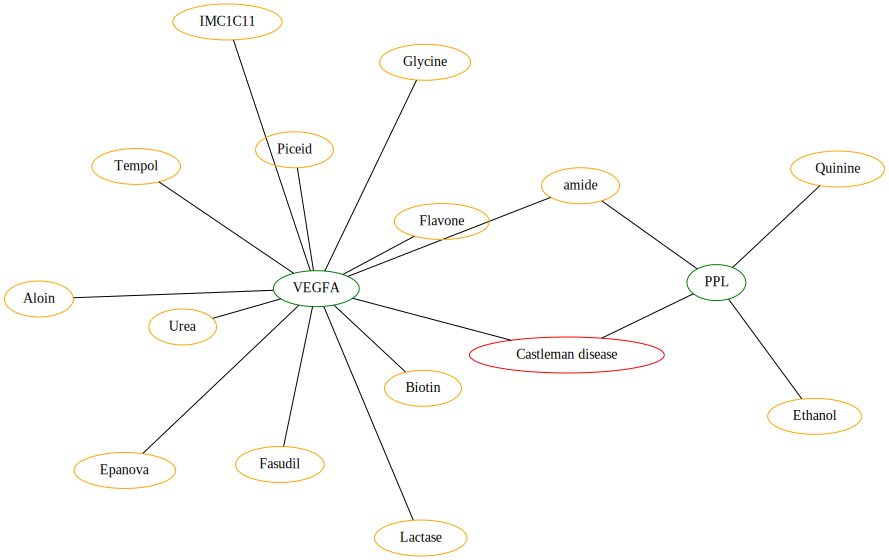

In [190]:
SVG('/home/ubuntu/PROJECTS/BIG_ROBOKOP_MAP/castleman_demo_v1.svg')

In [36]:
valid_smoothing_types = ["none","avg_dist","graph_dist","power_dist","rng","spring","triangle"]
#class ValidSmoothing(enum.StrEnum):
#    none = auto()
    
def drawSVG(G : pgv.AGraph, renderToNotebook : bool=True, repulsiveforce : float=1.0, K :float=0.3, smoothing_type : str="none", svg_fname : str='/home/ubuntu/PROJECTS/BIG_ROBOKOP_MAP/graph.svg'):
    if(smoothing_type not in valid_smoothing_types):raise ValueError
    G.layout(prog="sfdp", args=f"-Glevels=4 -Goverlap=scale -Grepulsiveforce={repulsiveforce} -GK={K} -Gsmoothing={smoothing_type}")
    G.draw(svg_fname)
    if(renderToNotebook): return SVG(svg_fname)

In [249]:
G = makeGraph(nodes,rels,8)
drawSVG(G,False,11.0,0.1,"none")

Approved nodes: 105


In [251]:
for smoothing in valid_smoothing_types:
    G = makeGraph(nodes,rels,8)
    drawSVG(G,False,11.0,0.1,smoothing)
    print(smoothing)
    input("Hi")

Approved nodes: 105
none
Approved nodes: 105
avg_dist
Approved nodes: 105
graph_dist
Approved nodes: 105
power_dist
Approved nodes: 105
rng
Approved nodes: 105
spring
Approved nodes: 105
triangle


In [254]:
G = makeGraph(nodes,rels,11)
drawSVG(G,False,11.0,0.1,"spring")

Approved nodes: 497


In [255]:
G = makeGraph(nodes,rels,11)
drawSVG(G,False,11.0,0.1,"graph_dist")

Approved nodes: 497


In [4]:
import string
l = string.ascii_lowercase[:14]

In [9]:
n=-1
for m,letter in enumerate(l):
    n+=1
    print(n)
    if(n==0):
        #n+=1
        continue
    elif(n==len(l)-1):
        #n+=1
        print("DONE!")
    else:
        #n+=1
        print(letter)
    

0
1
b
2
c
3
d
4
e
5
f
6
g
7
h
8
i
9
j
10
k
11
l
12
m
13
DONE!
